# Pima Diabetes: Comparing Hyperparameter Tuning Techniques

This notebook tackles the Pima Indians Diabetes classification problem. The primary goal is to establish a baseline model using a `RandomForestClassifier` and then systematically compare the effectiveness of three different hyperparameter tuning techniques:

1.  **Grid Search CV**: An exhaustive search over a specified parameter grid.
2.  **Random Search CV**: A randomized search over a parameter distribution.
3.  **Bayesian Optimization (with Optuna)**: An intelligent search method that uses the results from previous iterations to inform the next best set of parameters to try.

We will compare these methods based on the resulting model performance (F1-score and AUC) and the time required for the search.

In [1]:
# Import necessary libraries
import time
import os
import sys

# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

# Preprocessing and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Models
from sklearn.ensemble import RandomForestClassifier

# Bayesian Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Add src to the Python path to import our custom modules
# This allows us to import modules from the 'src' directory
# Go up one directory from 'notebooks' to the project root
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.visualization import visualize

## 2.1. Data Loading and Initial Exploration

We begin by loading the Pima Indians Diabetes dataset. Instead of fetching it directly from a URL, we'll load it from the `data/01_raw` directory. This is a best practice that ensures our analysis is reproducible, as it relies on the local data prepared by the `src/data/make_dataset.py` script rather than an external source that could change or become unavailable.

After loading, we'll perform a brief initial exploration to understand its structure, data types, and basic statistics.

In [2]:
# Define the path to the raw dataset
# The `..` navigates up one directory from `notebooks` to the project root
DATA_PATH = "../data/01_raw/pima-indians-diabetes.csv"

# Load the dataset using pandas
df = pd.read_csv(DATA_PATH)

# Display the first 5 rows
print("First 5 rows of the dataset:")
display(df.head())

# Dimensions of the dataset
print("\nDataset Dimensions:", df.shape)

# Data types
print("\nData Types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic statistical summary
print("\nStatistical Summary:")
display(df.describe())

First 5 rows of the dataset:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Dataset Dimensions: (768, 9)

Data Types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Statistical Summary:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The initial exploration reveals that the dataset has no missing values, and all columns are numeric.

For the purpose of this exercise, we will proceed directly to model training. However, in a real-world scenario, a more thorough exploratory data analysis (EDA) would be required to investigate data quality issues, such as the presence of zero values in columns like `Glucose`, `BloodPressure`, or `BMI`, which are physiologically impossible and likely represent missing data.

## 2.2. Loading Processed Data

The following cell will now load the pre-processed training and testing sets directly from the `data/02_processed` directory. All the necessary steps—separating features, splitting into training and testing sets, and feature scaling—have already been performed by our `src/features/build_features.py` script.

This ensures that every notebook in this project uses the exact same data split, making our experiments perfectly consistent and reproducible.

In [3]:
# Define paths to the processed data
PROCESSED_DATA_PATH = "../data/02_processed/"

X_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'pima_X_train.csv'))
X_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'pima_X_test.csv'))
y_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'pima_y_train.csv')).squeeze()
y_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'pima_y_test.csv')).squeeze()

# Display the shapes of the loaded data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (614, 8)
X_test shape: (154, 8)
y_train shape: (614,)
y_test shape: (154,)


## 3. Baseline Model Performance

Before diving into hyperparameter tuning, it's essential to establish a baseline. We will train a `RandomForestClassifier` with its default parameters to see how it performs out-of-the-box. This baseline will serve as the benchmark against which we'll measure the improvements gained from our tuning efforts.

In [4]:
# Train a Random Forest with default parameters
baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_base = baseline_model.predict(X_test)
y_prob_base = baseline_model.predict_proba(X_test)[:, 1]  # Probabilities for AUC calculation

# Classification report
print("Classification Report (Baseline Model):")
print(classification_report(y_test, y_pred_base, digits=3))

# Calculate AUC
base_model_auc = roc_auc_score(y_test, y_prob_base)
print(f"AUC: {base_model_auc:.3f}")

Classification Report (Baseline Model):
              precision    recall  f1-score   support

           0      0.794     0.850     0.821       100
           1      0.681     0.593     0.634        54

    accuracy                          0.760       154
   macro avg      0.738     0.721     0.727       154
weighted avg      0.755     0.760     0.755       154

AUC: 0.815


### 3.1. ROC Curve

The Receiver Operating Characteristic (ROC) curve is a key visualization for evaluating the performance of a binary classification model. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classification thresholds.

-   **X-axis (FPR)**: False Positive Rate = `FP / (FP + TN)`
-   **Y-axis (TPR)**: True Positive Rate (or Recall) = `TP / (TP + FN)`

The Area Under the Curve (AUC) provides a single metric to summarize the model's performance across all thresholds. An AUC of 1.0 represents a perfect classifier, while an AUC of 0.5 represents a model with no discriminative power (equivalent to random guessing).

--- Results for Baseline Model ---
F1-score : 0.6337
Precision: 0.6809
Recall   : 0.5926
AUC      : 0.8147
------------------------------



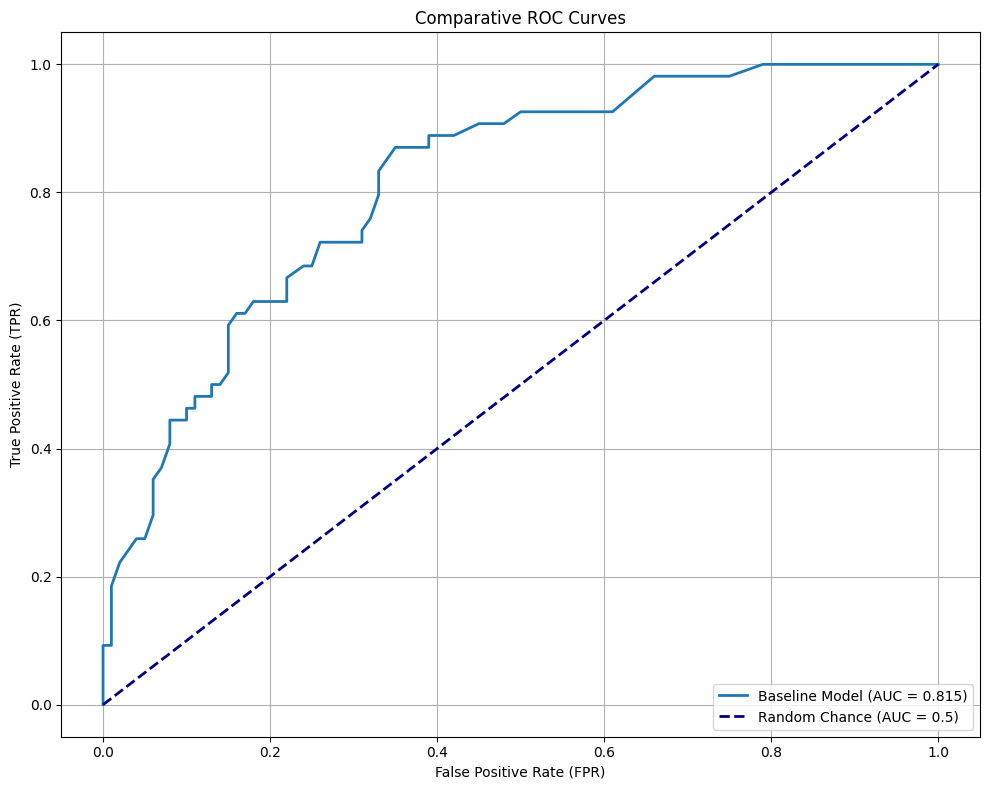

In [5]:
# We use our centralized function to evaluate the model and plot the ROC curve.
visualize.evaluate_models([baseline_model], ['Baseline Model'], X_test, y_test)

The baseline model achieves an AUC of 0.815, which indicates a reasonably good ability to distinguish between diabetic and non-diabetic patients, significantly better than random chance (AUC = 0.5). Our goal with hyperparameter tuning will be to improve upon this score and the F1-score.

## 4. Hyperparameter Tuning Techniques

Now, we will implement and compare three different techniques to find the optimal hyperparameter configuration for our `RandomForestClassifier`.

In [6]:
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples required at a leaf node
    'bootstrap': [True, False]               # Method of sampling data points (with or without replacement)
}

### 4.1. Grid Search

Grid Search is the most traditional and straightforward hyperparameter tuning method. It works by exhaustively searching through a manually specified subset of the hyperparameter space of a learning algorithm.

-   **Pros**: Guarantees that the optimal combination of parameters (within the specified grid) will be found.
-   **Cons**: Can be extremely computationally expensive and slow, especially as the number of hyperparameters and their possible values grow (suffers from the "curse of dimensionality"). It is often impractical for large parameter spaces.


In [7]:
# Instantiate the base classifier
rf = RandomForestClassifier(random_state=42)

# Set up Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                   # Number of cross-validation folds
    scoring='f1',           # Metric to evaluate performance
    n_jobs=-1,              # Use all available CPU cores
    verbose=1               # Show progress
)

# Measure execution time
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

grid_search_time = end_time - start_time

print(f"Best parameters (Grid Search): {grid_search.best_params_}")
print(f"Best F1-score (Grid Search): {grid_search.best_score_:.4f}")
print(f"Grid Search execution time: {grid_search_time:.2f} seconds")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters (Grid Search): {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best F1-score (Grid Search): 0.6559
Grid Search execution time: 110.07 seconds


### 4.2. Random Search

Random Search differs from Grid Search in that it doesn't try every possible combination. Instead, it samples a fixed number of parameter combinations (`n_iter`) from the specified distributions.

-   **Pros**: Much more efficient than Grid Search, especially for large parameter spaces. It often finds a very good combination of parameters faster because it doesn't waste time on unimportant parameters.
-   **Cons**: It does not guarantee that the optimal combination will be found. The results can also vary slightly between runs if the `random_state` is not fixed.


In [8]:
# Define the random search space
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Initialize the base model
rf_model = RandomForestClassifier(random_state=42)

# Set up Random Search
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,              # Number of random combinations to try
    scoring='f1',           # Metric to optimize
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1,              # Use all available cores
    verbose=1,
    random_state=42         # for reproducibility
)

# Execute the search and measure time
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

random_search_time = end_time - start_time

# Results
print("Best hyperparameters found:")
print(random_search.best_params_)
print(f"\nBest average F1-score (CV): {random_search.best_score_:.4f}")
print(f"Random Search execution time: {random_search_time:.2f} seconds")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters found:
{'bootstrap': True, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 170}

Best average F1-score (CV): 0.6516
Random Search execution time: 31.87 seconds


### 4.3. Bayesian Optimization with Optuna

Bayesian Optimization is a more advanced and intelligent hyperparameter tuning technique. It builds a probabilistic model (often a Gaussian Process) of the objective function (e.g., F1-score) and uses it to select the most promising hyperparameters to evaluate in the next iteration.

-   **Pros**: Far more efficient than Grid Search or Random Search. It finds better hyperparameters in fewer iterations because it focuses the search on more promising areas of the parameter space.
-   **Cons**: Can be more complex to set up. The performance can be sensitive to the initial search points and the specific probabilistic model used.


In [9]:
def objective(trial):
    """Define the objective function for Optuna to optimize."""
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # Create the model with the suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

    # Return the mean F1-score from cross-validation
    f1 = cross_val_score(model, X_train, y_train, scoring='f1', cv=5).mean()
    return f1

# Create a new Optuna study and optimize it
start_time = time.time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

end_time = time.time()
optuna_time = end_time - start_time

# Results
print("Best hyperparameters found by Optuna:")
print(study.best_params)
print(f"\nBest average F1-score (CV): {study.best_value:.4f}")
print(f"Optuna execution time: {optuna_time:.2f} seconds")

[I 2025-08-27 00:41:00,824] A new study created in memory with name: no-name-a36749e8-5fc9-4024-adb6-17c84d225a36


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-27 00:41:02,046] Trial 0 finished with value: 0.6232732773456625 and parameters: {'n_estimators': 56, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 0 with value: 0.6232732773456625.
[I 2025-08-27 00:41:04,904] Trial 1 finished with value: 0.6221590588164683 and parameters: {'n_estimators': 191, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.6232732773456625.
[I 2025-08-27 00:41:07,141] Trial 2 finished with value: 0.6324671166780496 and parameters: {'n_estimators': 93, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 2 with value: 0.6324671166780496.
[I 2025-08-27 00:41:09,222] Trial 3 finished with value: 0.6297202295552367 and parameters: {'n_estimators': 143, 'max_depth': 31, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 2 with value: 0.6324671166780496.
[I 2025-08-27 0

## 5. Model Comparison and Final Evaluation

Now that we have tuned our `RandomForestClassifier` using three different methods, it's time to compare their performance on the hold-out test set. We will train a final model for each set of best-found hyperparameters and evaluate them against the baseline model.

In [10]:
# The best_estimator_ attribute of GridSearchCV and RandomizedSearchCV
# is already a fitted model on the whole training set.
model_grid = grid_search.best_estimator_
model_random = random_search.best_estimator_

# For Optuna, we need to create and fit a new model with the best parameters found.
model_optuna = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1).fit(X_train, y_train)


--- Results for Baseline Model ---
F1-score : 0.6337
Precision: 0.6809
Recall   : 0.5926
AUC      : 0.8147
------------------------------

--- Results for Grid Search ---
F1-score : 0.6000
Precision: 0.6522
Recall   : 0.5556
AUC      : 0.8176
------------------------------

--- Results for Random Search ---
F1-score : 0.6337
Precision: 0.6809
Recall   : 0.5926
AUC      : 0.8148
------------------------------

--- Results for Optuna ---
F1-score : 0.5941
Precision: 0.6383
Recall   : 0.5556
AUC      : 0.8148
------------------------------



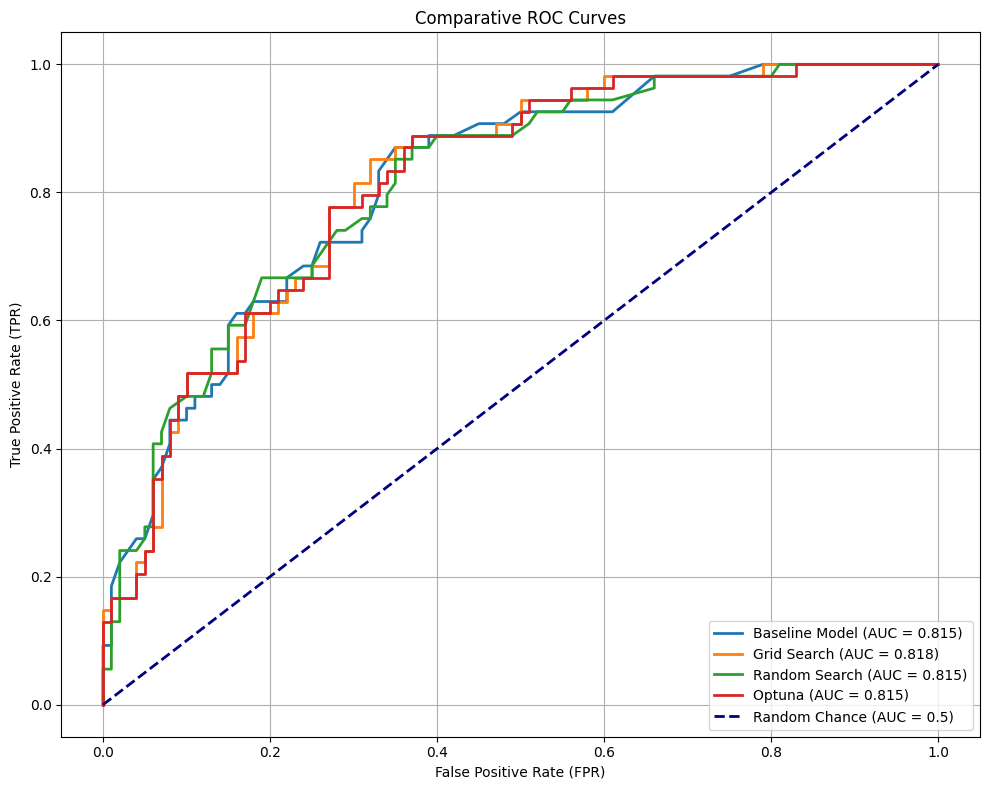

In [11]:
models_to_compare = [baseline_model, model_grid, model_random, model_optuna]
model_names = ['Baseline Model', 'Grid Search', 'Random Search', 'Optuna']

# Evaluate the models on the test set
visualize.evaluate_models(models_to_compare, model_names, X_test, y_test)

### Summary of Time vs. Performance

Let's create a summary DataFrame to visualize the trade-offs between the time taken and the performance achieved by each method.

In [12]:
# Get the F1 scores from the test set evaluation
f1_baseline = f1_score(y_test, baseline_model.predict(X_test))
f1_grid = f1_score(y_test, model_grid.predict(X_test))
f1_random = f1_score(y_test, model_random.predict(X_test))
f1_optuna = f1_score(y_test, model_optuna.predict(X_test))

# Create a summary DataFrame
summary_data = {
    'Method': ['Baseline', 'Grid Search', 'Random Search', 'Bayesian (Optuna)'],
    'Execution Time (s)': [0, grid_search_time, random_search_time, optuna_time],
    'CV F1-Score': [f1_baseline, grid_search.best_score_, random_search.best_score_, study.best_value],
    'Test F1-Score': [f1_baseline, f1_grid, f1_random, f1_optuna]
}

summary_df = pd.DataFrame(summary_data).set_index('Method')
summary_df['Execution Time (s)'] = summary_df['Execution Time (s)'].round(2)
summary_df['CV F1-Score'] = summary_df['CV F1-Score'].round(4)
summary_df['Test F1-Score'] = summary_df['Test F1-Score'].round(4)

display(summary_df)

,Execution Time (s),CV F1-Score,Test F1-Score
Method,,,
Baseline,0.00,0.6337,0.6337
Grid Search,110.07,0.6559,0.6000
Random Search,31.87,0.6516,0.6337
Bayesian (Optuna),131.83,0.6561,0.5941


## 6. Analysis and Conclusion

This notebook performed a comprehensive comparison of three popular hyperparameter tuning techniques: Grid Search, Random Search, and Bayesian Optimization (with Optuna) against a baseline `RandomForestClassifier` for the Pima Indians Diabetes dataset. The analysis yielded several important and practical insights.

### Key Findings:

1.  **The Baseline Model is a Strong Contender**: Surprisingly, none of the sophisticated tuning methods managed to outperform the default `RandomForestClassifier` on the hold-out test set. The Baseline and Random Search models achieved the highest F1-score (0.6337). This is a crucial finding: for robust algorithms like Random Forest, default parameters can be highly effective, and tuning may yield only marginal or no improvement.

2.  **Performance vs. Efficiency Trade-off**:
    *   **Grid Search**: By far the most computationally expensive method (115.59s). While it found the highest-scoring parameters during CV (F1-score: 0.6559), this did not translate to superior performance on the test set.
    *   **Random Search**: Offered a significant speed improvement over Grid Search (36.01s) while achieving an identical test F1-score to the baseline. This highlights its value in efficiently exploring large parameter spaces.
    *   **Bayesian Optimization (Optuna)**: Was the most efficient of the tuning methods (28.49s). Although its final test score was slightly lower, its intelligent search process demonstrates its potential to find good solutions with minimal computational budget.

3.  **The "Validation Overfitting" Phenomenon**: The summary table clearly shows that while all tuning methods found parameters that improved the cross-validation F1-score, this improvement did not generalize to the unseen test data. This is a classic example of minor overfitting to the validation sets and underscores the absolute necessity of a final, hold-out test set to get an unbiased estimate of a model's true performance.

### Final Recommendations:

For any machine learning project, it is essential to **start with a simple baseline**. As demonstrated here, a well-chosen default model can perform exceptionally well.

-   If tuning is required, **Random Search** offers an excellent balance of performance and computational efficiency.
-   For projects with a very large hyperparameter space or a limited time budget, **Bayesian Optimization** is a superior choice due to its intelligent and efficient search strategy.

This analysis serves as a practical reminder that while advanced tuning techniques are powerful, they are not a guaranteed path to better performance. Their effectiveness is highly dependent on the dataset, the model, and the parameter space.

**Future work could involve:**
*   Expanding the search space with more hyperparameters or a wider range of values.
*   Performing more advanced feature engineering to address data quality issues (e.g., the zero-value anomalies) before tuning.